In [22]:
import pandas as pd
import Preprocessing_and_encoding as preprocess
import Randomiser as rr
import Budget_division as bd
import pandas as pd
import numpy as np
import random
import Helper as hp
import Synthesiser as sy
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import collections
import Statistical_analysis as sa
import json

In [2]:
no_of_users = 10000
# Input: granularity levels with ranges(d-levels)
appliance_list = appliance_list = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10']
n = len(appliance_list) # Number of appliances
no_of_days = 60
no_of_appliances = n
skew = -4  # 4
loc = 800 #2000  
scale = 1500 # 500
sensitivity = 2*n

user_appliance_energy_dict_days = {}

domain = ['l10', 'l9', 'l8', 'l7', 'l6', 'l5', 'l4', 'l3', 'l2', 'l1' ]
range_levels = {
  "l1": "0-250",
  "l2": "250-500",
  "l3": "500-750",
  "l4": "750-1000",
  "l5": "1000-1250",
  "l6": "1250-1500",
  "l7": "1500-1750",
  "l8": "1750-2000",
  "l9": "2000-2500",
  "l10": "2500"
}

#Tuning parameters
epsilon = 2 # 0 < ε ≤ 10
# alpha = 10 # 4-10
window_size = 2
user_appliance_list = {}
user_actual_value = {}
user_perturbed_data_list = {}
user_true_level_list = {}
user_perturbed_level_list = {}
appliance_level_list = {}
appliance_level_count = {}
appliance_level_average = {}
appliance_level_max = {}
appliance_perturbed_level_count = {}
appliance_perturbed_level_average = {}
appliance_perturbed_level_max = {}

In [3]:
#Synthetic data creation
user_appliance_energy_dict_days = sy.skewed_distribution_synthesising(appliance_list, no_of_users, no_of_days,
                                                                      no_of_appliances, skew, loc, scale)

In [4]:
user_appliance_energy_dict_days['U1']

{'day1': {'A1': 1.0,
  'A2': 462.9612890267381,
  'A3': 153.1783857495751,
  'A4': 1.0,
  'A5': 532.2472141464691,
  'A6': 1.0,
  'A7': 1.0,
  'A8': 1.0,
  'A9': 394.98863139353915,
  'A10': 1.0},
 'day2': {'A1': 1.0,
  'A2': 1.0,
  'A3': 384.0301406103989,
  'A4': 525.7558094122422,
  'A5': 1.0,
  'A6': 1.0,
  'A7': 180.8918125409895,
  'A8': 469.98250787343267,
  'A9': 1.0,
  'A10': 1.0},
 'day3': {'A1': 1.0,
  'A2': 1.0,
  'A3': 1.0,
  'A4': 1.0,
  'A5': 1.0,
  'A6': 100.6192736364665,
  'A7': 1.0,
  'A8': 1.0,
  'A9': 1.0,
  'A10': 229.5634683326436},
 'day4': {'A1': 1.0,
  'A2': 1.0,
  'A3': 1.0,
  'A4': 525.3807255939445,
  'A5': 1.0,
  'A6': 327.4079309438515,
  'A7': 1.0,
  'A8': 81.0403955792181,
  'A9': 63.118044792262985,
  'A10': 567.9168097575697},
 'day5': {'A1': 1006.4452919175077,
  'A2': 1.0,
  'A3': 1.0,
  'A4': 1.0,
  'A5': 1.0,
  'A6': 1.0,
  'A7': 1.0,
  'A8': 1.0,
  'A9': 1.0,
  'A10': 435.58843268740293},
 'day6': {'A1': 1.0,
  'A2': 1.0,
  'A3': 232.192693982992

In [5]:
user_appliance_energy_dict_days['U2']['day1']

{'A1': 247.07401574312323,
 'A2': 1.0,
 'A3': 1.0,
 'A4': 1.0,
 'A5': 603.1782134095155,
 'A6': 1.0,
 'A7': 1.0,
 'A8': 220.34803170701935,
 'A9': 1.0,
 'A10': 326.12887970985423}

# LBU

In [5]:
for k in range(no_of_users):
      # Appliance_energy dictionary per day for 30 days. In appliance_energy_dict_days, key specifies the day
    # (day 1, 2, 3...), and value represents the dictionary of  appliances with their energy consumption for the day.
    window_appliance_data = []
    window_binary_array_data = []
    appliance_energy_dict_days = user_appliance_energy_dict_days['U' + str(k+1)]

    #Encode the energy data into energy levels (granularity levels)
    for key, value in appliance_energy_dict_days.items():
        true_energy_levels_dict = preprocess.create_appliance_energy_encoding(appliance_energy_dict_days[key], range_levels)
        # Declare, l = (d*n); // d- number of granular levels, n- number of appliances
        # Generate a long binary string B with the length of l by merging the binary arrays
        binary_array = []
        for i in range(len(true_energy_levels_dict)):
            binary_array.append(list(true_energy_levels_dict.values())[i])
        binary_array = np.array(binary_array).flatten()

        window_appliance_data.append(true_energy_levels_dict.values())
        window_binary_array_data.append(binary_array)

    perturbed_data_window_lbd = []
    perturbed_data_window_lba = []
    #LBD parameters
    previously_spent_epsilons = []
    previously_released = []
    published_epsilons_et2 = []
    #LBA parameters
    nullify = []
    window_iterate = 0
    actual_data = []
    current_timestamp = 0
    previously_spent_et2_lba = []

    perturbed_data_window_uniform = []
    perturbed_data_window_sampling = []
    # Adding the encoded data in a sliding window format for our calculation
    for window in hp.sliding_window(window_binary_array_data, window_size):
        current_window = window
        window_iterate = window_iterate + 1
        if window_iterate == 1:
            current_window = current_window
        else:
            a = current_window[window_size-1]
            current_window = []
            current_window.append(a.tolist())
            # previously_spent_et2.pop(0)
            # nullify.pop(0)

        actual_data.append(current_window)


        # Adaptive Budget division
        # Generate a random number to determine which sampling timestamp to select for use in the LDP sampling method.
        sampling_timestamp = random.randint(window_iterate, (window_iterate+window_size)-1)
        perturbed_data_sampling = []

        for i in range(len(current_window)):
            # LDP Budget uniform method
            uniform_epsilon = bd.uniform_budget(window_size)
            # Scenario2: Combined array with unary encoding
            perturbed_data_uniform = rr.optimised_unary_perturbation(current_window[i], sensitivity,
                                                                     epsilon=uniform_epsilon)
            perturbed_data_window_uniform.append(perturbed_data_uniform)

    user_perturbed_data_list['U' + str(k + 1)] = perturbed_data_window_uniform
    user_actual_value['U' + str(k + 1)] = window_binary_array_data

    day_data = {}
    # Appliances true energy levels
    for i in range(no_of_days):
        a = hp.true_data_appliance_level(user_actual_value['U' + str(k + 1)][i], len(domain), n)
        day_data["day" + str(i + 1)] = a
    user_true_level_list['U' + str(k + 1)] = day_data

    day_perturbed_data = {}
    # Appliances perturbed energy levels
    for i in range(no_of_days):
        b = hp.perturbed_data_appliance_level(user_perturbed_data_list['U' + str(k + 1)][i], len(domain), n)
        day_perturbed_data["day" + str(i + 1)] = b
    user_perturbed_level_list['U' + str(k + 1)] = day_perturbed_data

In [7]:
user_perturbed_level_list['U1']

{'day1': {'A1': [0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
  'A2': [0, 0, 1, 1, 0, 1, 1, 1, 1, 0],
  'A3': [0, 1, 0, 0, 1, 0, 1, 0, 1, 0],
  'A4': [1, 1, 1, 0, 1, 0, 0, 0, 0, 1],
  'A5': [0, 0, 0, 0, 1, 0, 0, 0, 1, 1],
  'A6': [0, 1, 1, 1, 0, 1, 1, 0, 0, 0],
  'A7': [0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
  'A8': [1, 1, 1, 0, 0, 0, 0, 0, 1, 0],
  'A9': [1, 0, 1, 1, 1, 0, 0, 1, 1, 1],
  'A10': [1, 0, 0, 0, 0, 1, 0, 1, 1, 1]},
 'day2': {'A1': [1, 1, 0, 0, 1, 0, 1, 1, 0, 0],
  'A2': [0, 0, 0, 1, 1, 0, 1, 1, 1, 1],
  'A3': [1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
  'A4': [0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
  'A5': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
  'A6': [0, 0, 0, 1, 0, 1, 1, 1, 1, 1],
  'A7': [1, 0, 0, 0, 1, 1, 1, 0, 1, 0],
  'A8': [0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
  'A9': [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
  'A10': [0, 0, 0, 1, 1, 1, 0, 0, 0, 1]},
 'day3': {'A1': [1, 0, 0, 0, 0, 1, 0, 0, 1, 1],
  'A2': [0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
  'A3': [1, 0, 1, 0, 1, 1, 1, 1, 1, 0],
  'A4': [0, 0, 1, 0, 1, 0, 1, 0, 1, 0],
  'A5': [1, 

# LSP

In [8]:
for k in range(no_of_users):
      # Appliance_energy dictionary per day for 30 days. In appliance_energy_dict_days, key specifies the day
    # (day 1, 2, 3...), and value represents the dictionary of  appliances with their energy consumption for the day.
    window_appliance_data = []
    window_binary_array_data = []
    appliance_energy_dict_days = user_appliance_energy_dict_days['U' + str(k+1)]

    #Encode the energy data into energy levels (granularity levels)
    for key, value in appliance_energy_dict_days.items():
        true_energy_levels_dict = preprocess.create_appliance_energy_encoding(appliance_energy_dict_days[key], range_levels)
        # Declare, l = (d*n); // d- number of granular levels, n- number of appliances
        # Generate a long binary string B with the length of l by merging the binary arrays
        binary_array = []
        for i in range(len(true_energy_levels_dict)):
            binary_array.append(list(true_energy_levels_dict.values())[i])
        binary_array = np.array(binary_array).flatten()

        window_appliance_data.append(true_energy_levels_dict.values())
        window_binary_array_data.append(binary_array)

    perturbed_data_window_lbd = []
    perturbed_data_window_lba = []
    #LBD parameters
    previously_spent_epsilons = []
    previously_released = []
    published_epsilons_et2 = []
    #LBA parameters
    nullify = []
    window_iterate = 0
    actual_data = []
    current_timestamp = 0
    previously_spent_et2_lba = []

    perturbed_data_window_uniform = []
    perturbed_data_window_sampling = []
    # Adding the encoded data in a sliding window format for our calculation
    for window in hp.sliding_window(window_binary_array_data, window_size):
        current_window = window
        window_iterate = window_iterate + 1
        if window_iterate == 1:
            current_window = current_window
        else:
            a = current_window[window_size-1]
            # current_window = []
            # current_window.append(a.tolist())
            # previously_spent_et2.pop(0)
            # nullify.pop(0)

        actual_data.append(current_window)


        # Adaptive Budget division
        # Generate a random number to determine which sampling timestamp to select for use in the LDP sampling method.
        sampling_timestamp = random.randint(1, window_size)
        perturbed_data_sampling = []

        for i in range(len(current_window)):
            # LDP Sampling Method
            sampling_epsilon = bd.sampling_budget(sampling_timestamp, i + 1, epsilon)
            if (sampling_epsilon == 0):
                perturbed_data_sampling = perturbed_data_sampling
            else:
                # Scenario2: Combined array with unary encoding
                perturbed_data_sampling = rr.optimised_unary_perturbation(current_window[i], sensitivity,
                                                                          epsilon=sampling_epsilon)
        if window_iterate == 1:
            perturbed_data_window_sampling = [perturbed_data_sampling] * window_size
        else:
            perturbed_data_window_sampling.append(perturbed_data_sampling)


    user_perturbed_data_list['U' + str(k + 1)] = perturbed_data_window_sampling
    user_actual_value['U' + str(k + 1)] = window_binary_array_data

    day_data = {}
    # Appliances true energy levels
    for i in range(no_of_days):
        a = hp.true_data_appliance_level(user_actual_value['U' + str(k + 1)][i], len(domain), n)
        day_data["day" + str(i + 1)] = a
    user_true_level_list['U' + str(k + 1)] = day_data

    day_perturbed_data = {}
    # Appliances perturbed energy levels
    for i in range(no_of_days):
        b = hp.perturbed_data_appliance_level(user_perturbed_data_list['U' + str(k + 1)][i], len(domain), n)
        day_perturbed_data["day" + str(i + 1)] = b
    user_perturbed_level_list['U' + str(k + 1)] = day_perturbed_data

# LBD

In [11]:
for k in range(no_of_users):
      # Appliance_energy dictionary per day for 30 days. In appliance_energy_dict_days, key specifies the day
    # (day 1, 2, 3...), and value represents the dictionary of  appliances with their energy consumption for the day.
    window_appliance_data = []
    window_binary_array_data = []
    appliance_energy_dict_days = user_appliance_energy_dict_days['U' + str(k+1)]

    #Encode the energy data into energy levels (granularity levels)
    for key, value in appliance_energy_dict_days.items():
        true_energy_levels_dict = preprocess.create_appliance_energy_encoding(appliance_energy_dict_days[key], range_levels)
        # Declare, l = (d*n); // d- number of granular levels, n- number of appliances
        # Generate a long binary string B with the length of l by merging the binary arrays
        binary_array = []
        for i in range(len(true_energy_levels_dict)):
            binary_array.append(list(true_energy_levels_dict.values())[i])
        binary_array = np.array(binary_array).flatten()

        window_appliance_data.append(true_energy_levels_dict.values())
        window_binary_array_data.append(binary_array)

    perturbed_data_window_lbd = []
    perturbed_data_window_lba = []
    #LBD parameters
    previously_spent_epsilons = []
    previously_released = []
    published_epsilons_et2 = []
    #LBA parameters
    nullify = []
    window_iterate = 0
    actual_data = []
    current_timestamp = 0
    previously_spent_et2_lba = []
    # Adding the encoded data in a sliding window format for our calculation
    for window in hp.sliding_window(window_binary_array_data, window_size):
        current_window = window
        window_iterate = window_iterate + 1
        if window_iterate == 1:
            current_window = current_window
        else:
            a = current_window[window_size-1]
            current_window = []
            current_window.append(a.tolist())
            previously_spent_et2.pop(0)
            # nullify.pop(0)

        actual_data.append(current_window)

        # Adaptive Budget division
        # Generate a random number to determine which sampling timestamp to select for use in the LDP sampling method.
        sampling_timestamp = random.randint(window_iterate, (window_iterate+window_size)-1)
        perturbed_data_sampling = []

        for i in range(len(current_window)):

            # LDP Budget Distribution method
            perturbed_data_lbd, previously_spent_et2 = bd.local_budget_distribution(window_size, current_window[i],
                                                                                     previously_spent_epsilons, published_epsilons_et2,
                                                                                     previously_released, sensitivity, epsilon)
            perturbed_data_window_lbd.append(perturbed_data_lbd)
            previously_released = perturbed_data_lbd

    user_perturbed_data_list['U' + str(k+1) ] = perturbed_data_window_lbd
    user_actual_value['U' + str(k+1)] = window_binary_array_data

    day_data ={}
    #Appliances true energy levels
    for i in range (no_of_days):
        a = hp.true_data_appliance_level(user_actual_value['U' + str(k+1) ][i], len(domain), n)
        day_data["day" + str(i + 1)] = a
    user_true_level_list['U' + str(k+1)] = day_data

    day_perturbed_data = {}
    #Appliances perturbed energy levels
    for i in range(no_of_days):
        b = hp.perturbed_data_appliance_level(user_perturbed_data_list['U' + str(k+1) ][i], len(domain), n)
        day_perturbed_data["day" + str(i + 1)] = b
    user_perturbed_level_list['U' + str(k+1)] = day_perturbed_data



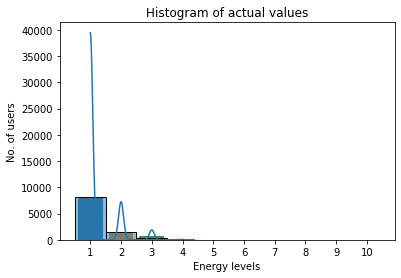

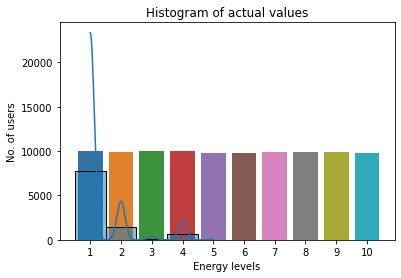

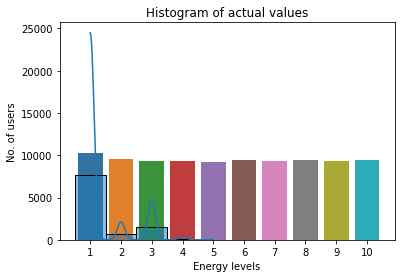

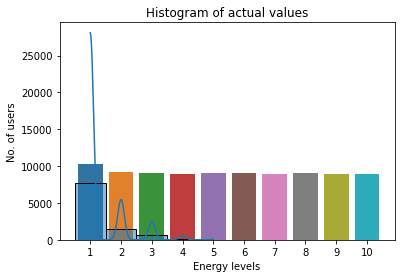

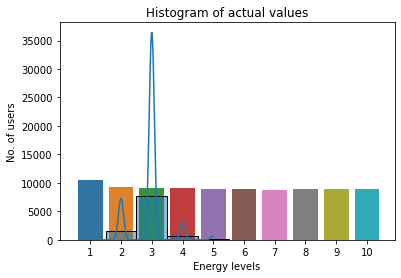

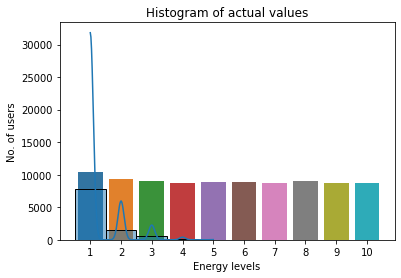

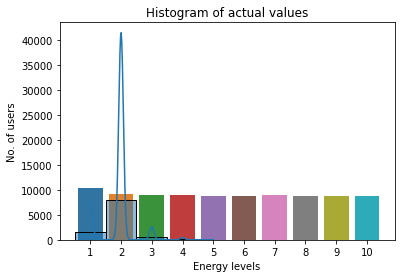

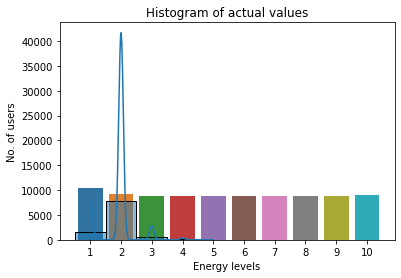

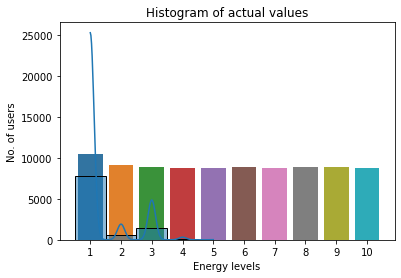

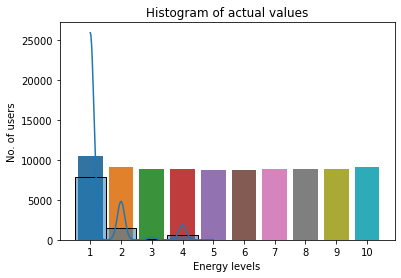

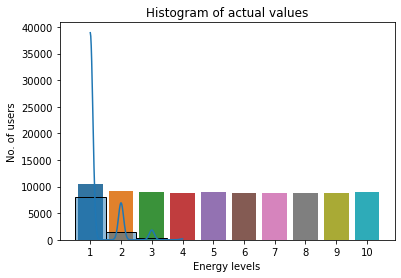

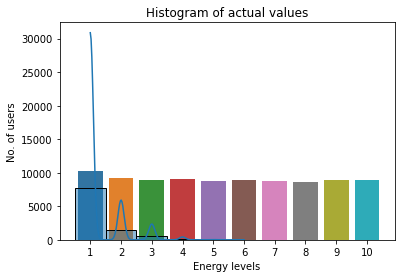

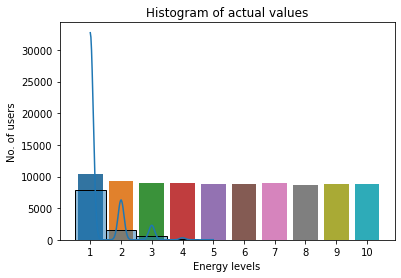

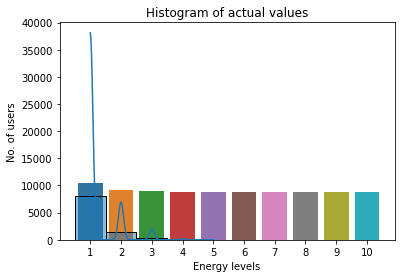

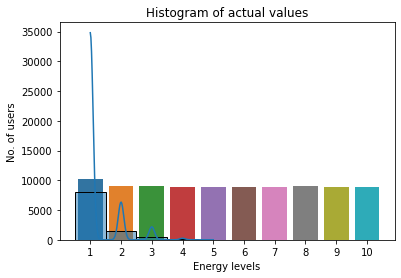

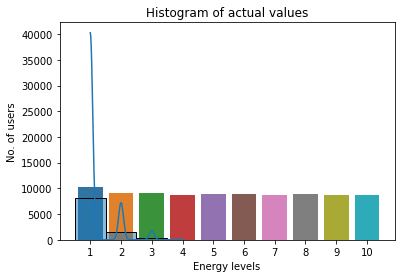

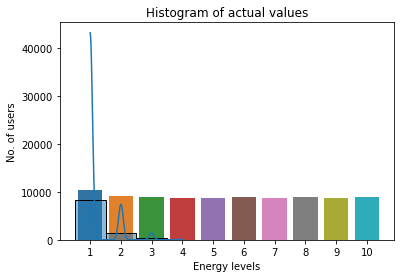

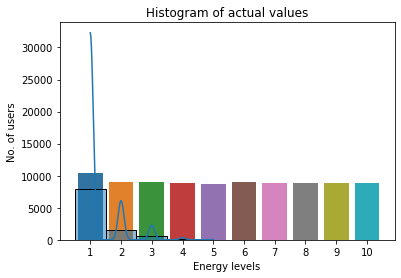

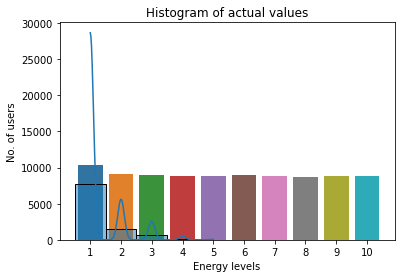

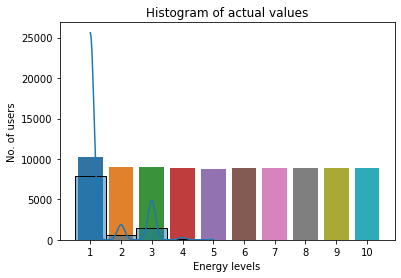

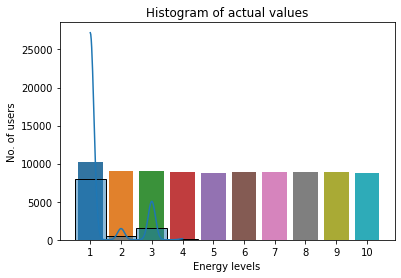

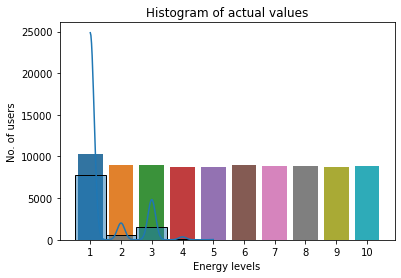

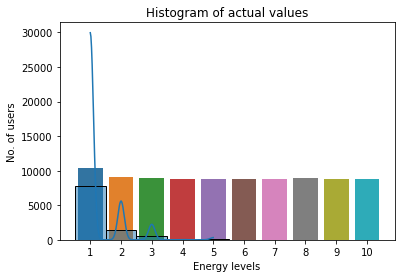

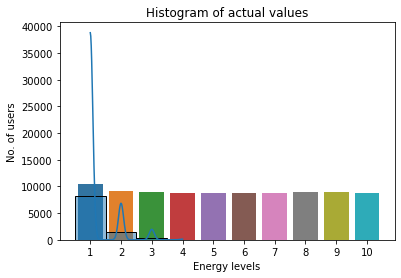

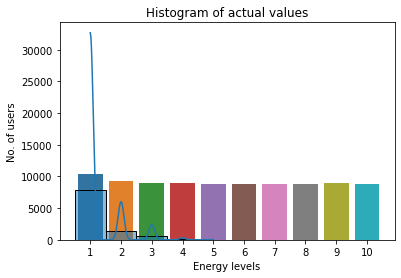

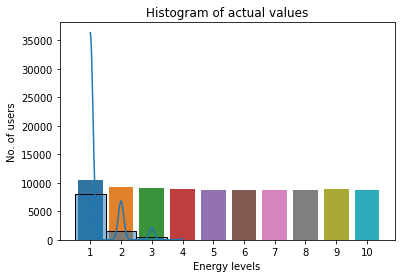

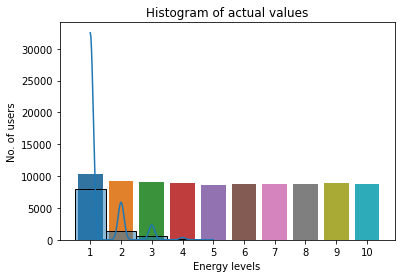

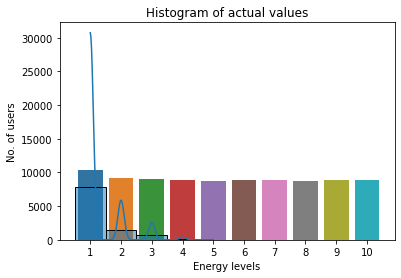

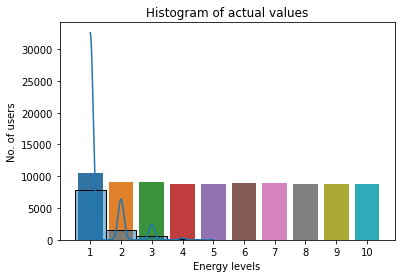

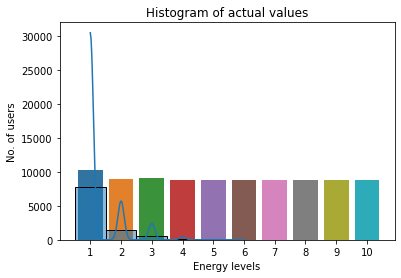

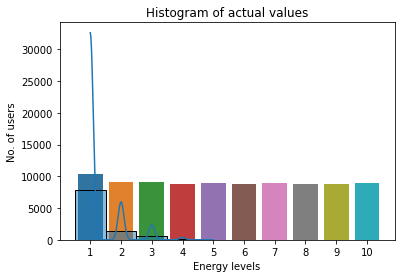

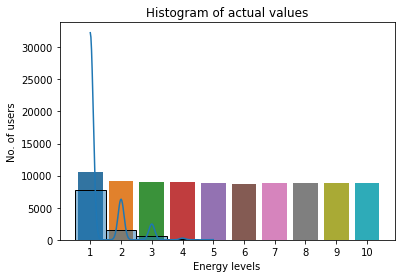

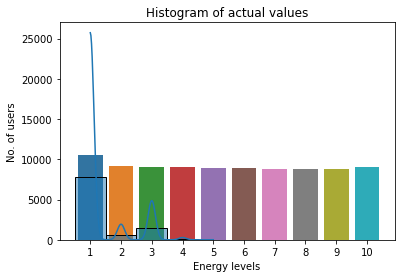

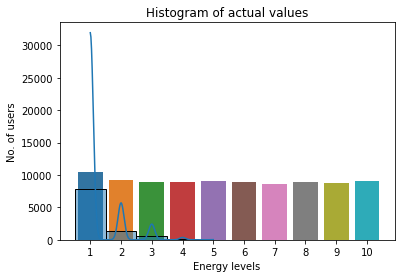

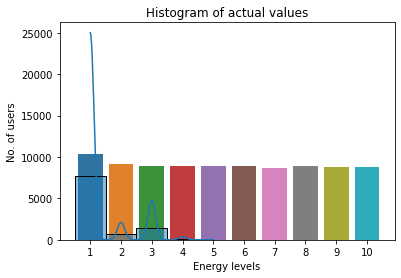

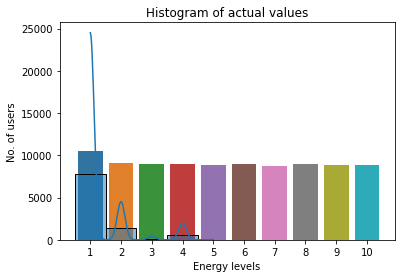

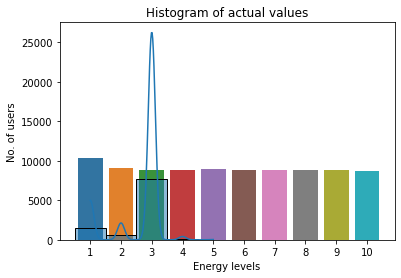

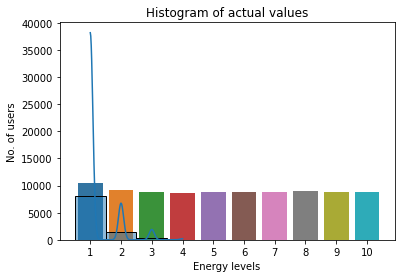

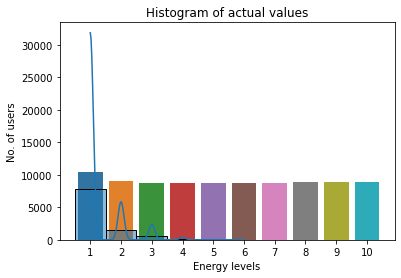

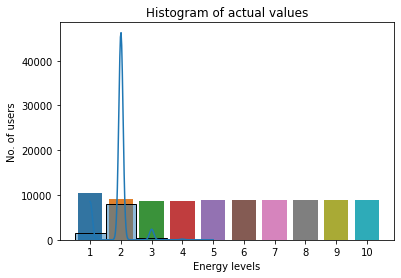

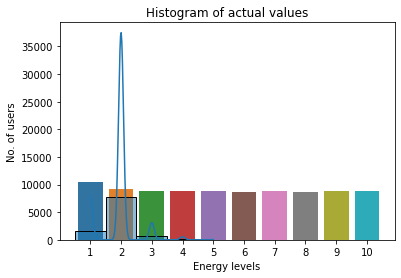

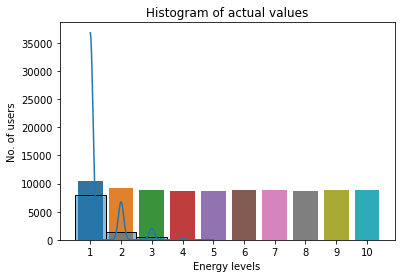

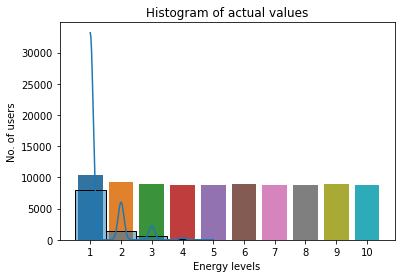

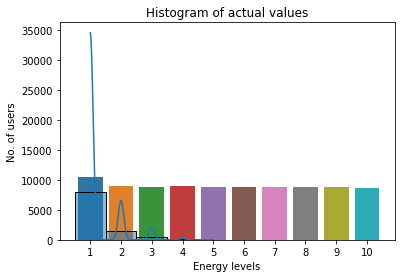

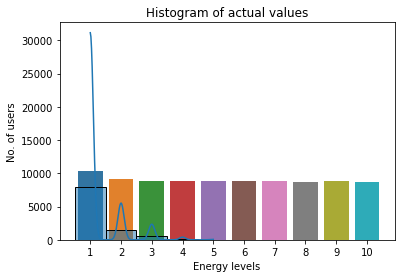

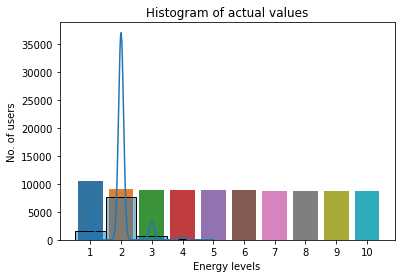

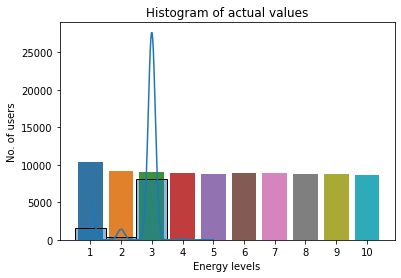

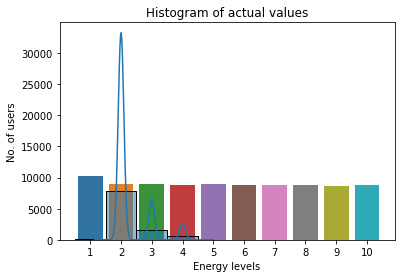

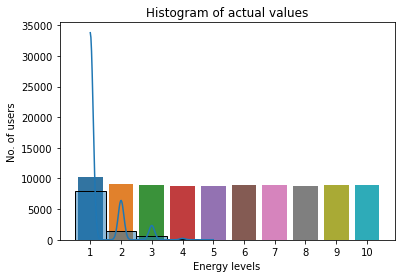

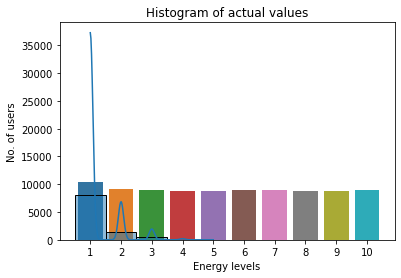

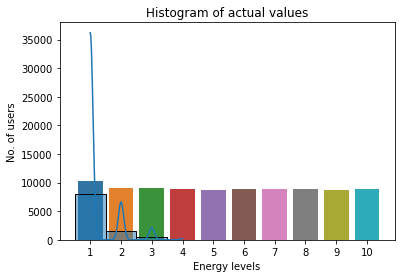

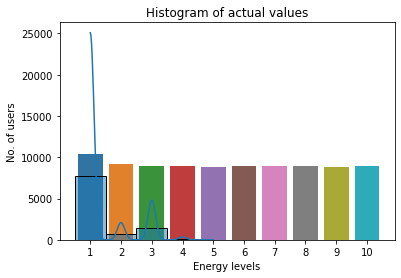

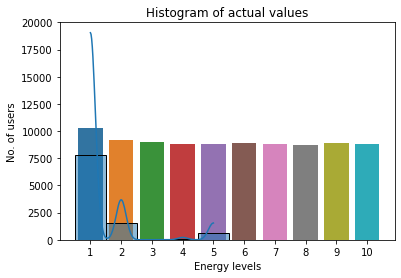

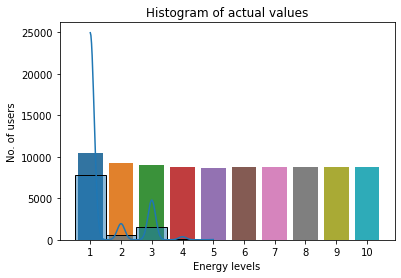

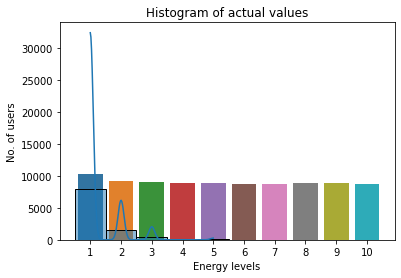

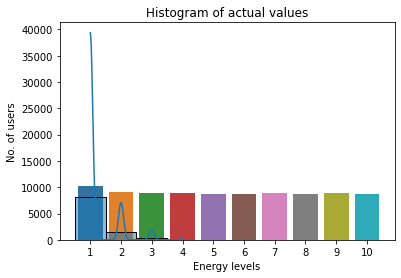

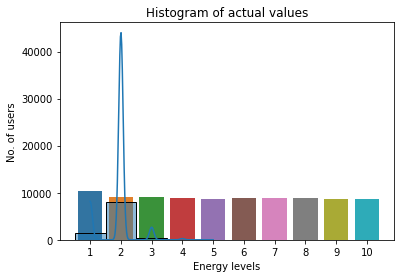

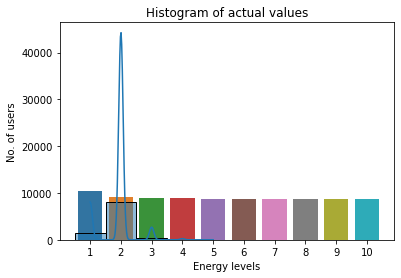

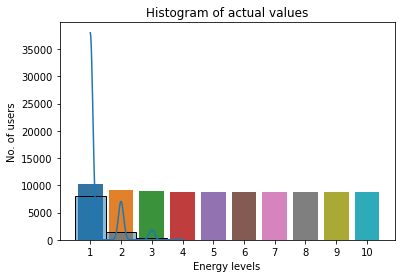

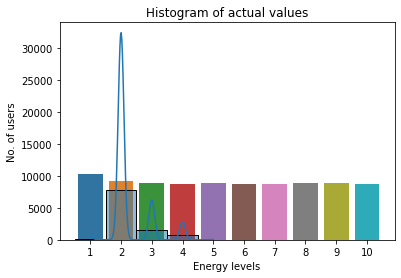

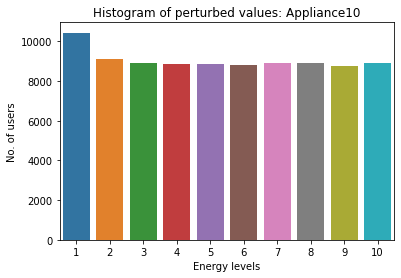

In [15]:
final_output = {}
#For true value aggregation and level mapping
for w in range(no_of_days):
    for i in range(n):
        all_user_appliance_true_values = []
        for j in range(no_of_users):
            appliance_data = user_true_level_list['U' + str(j+1)]['day' + str(w+1)]['A' + str(i+1)]
            all_user_appliance_true_values.append(appliance_data)
        levels =  hp.frequency_estimation_true_value(all_user_appliance_true_values, domain)
        counter = collections.Counter(levels)
        appliance_level_list['A' + str(i + 1)] = levels
        appliance_level_count['A' + str(i + 1)] = counter
        appliance_level_count = {k: dict(v) for k, v in appliance_level_count.items()}
        # Calculating average energy consumption: True value
        appliance_average, max_value = hp.average_calculation(counter, range_levels, domain)
        appliance_level_average['A' + str(i + 1)] = appliance_average
        appliance_level_max['A' + str(i + 1)] = max_value


    appliance_level_count_full = {}
    for j in range(len(appliance_level_count)):
        level_dic = {}
        diff = list(set(domain).symmetric_difference(set(list(list(appliance_level_count.values())[j].keys()))))
        for k in range(len(list(list(appliance_level_count.values())[j].keys()))):
            level_dic[int(list(list(appliance_level_count.values())[j].keys())[k].replace('l', ''))] \
                = list(list(appliance_level_count.values())[j].values())[k]
        for i in range(len(diff)):
            level_dic[int(diff[i].replace('l', ''))] = 0
        level_dic = OrderedDict(sorted(level_dic.items()))
        
        title_actual = 'Histogram of actual values: Appliance' + str(j+1)

        ax = sns.barplot(x=list(level_dic.keys()), y=list(level_dic.values()))
        ax.set(xlabel='Energy levels', ylabel='No. of users', title=title_actual)
        saveTitle = 'results/skew/lba/plotAc ' + str(w)+ ' '+ str(j+1) +'.pdf'
        plt.savefig(saveTitle)

        appliance_level_count_full['A' + str(j + 1)] = level_dic

    # Plotting the histogram: true values    
    ax = sns.histplot(data = appliance_level_list['A1'], kde=True)
    ax.set(xlabel='Energy levels', ylabel='No. of users', title='Histogram of actual values')
    plt.show()

    #For perturbed value aggregation
    for i in range (n):
        all_user_appliance_perturbed_values = []
        for j in range (no_of_users):
            appliance_data = user_perturbed_level_list['U' + str(j+1)]['day' + str(w+1)]['A' + str(i+1) ]
            all_user_appliance_perturbed_values.append(appliance_data)
        # Estimation and aggregation
        estimated_answers = hp.estimation_from_perturbed_value(all_user_appliance_perturbed_values, sensitivity, epsilon)
        levels_with_count = dict(zip(domain, estimated_answers))
        res = OrderedDict(reversed(list(levels_with_count.items())))
        res_new = {}
        for j in range(len(list(res.keys()))):
            res_new[j + 1] = list(res.values())[j]
        appliance_perturbed_level_count['A' + str(i + 1)] = res_new
        
        # Plotting the histogram: perturbed values
        title_perturbed = 'Histogram of perturbed values: Appliance' + str(i+1)
        ax = sns.barplot(x=list(res_new.keys()), y=list(res_new.values()))
        ax.set(xlabel='Energy levels', ylabel='No. of users', title=title_perturbed)
        savepTitle = 'results/skew/lba/plotPer ' + str(w)+ ' '+ str(i+1) +'.pdf'
        plt.savefig(savepTitle)

    output_appliance = {}
    
# Statistical analysis I: mean/variance analysis
    for k in range(len(appliance_list)):
        
        overall_values = {}
        a = appliance_level_count_full['A' + str(k+1)]
        temp_actual = list(a.keys())
        count_actual = list(a.values())
        final_actual_data = []

        for i in range(len(temp_actual)):
            for j in range (count_actual[i]):
                final_actual_data.append(temp_actual[i])

        b = appliance_perturbed_level_count['A' + str(k+1)]
        temp = list(b.keys())
        counte = list(b.values())
        final_perturbed_data = []

        for i in range(len(temp)):
            for j in range (counte[i]):
                final_perturbed_data.append(temp[i])

        mean_actual = sum(final_actual_data) / len(final_actual_data)
        variance_actual = sum((i - mean_actual) ** 2 for i in final_actual_data) / len(final_actual_data)

        mean = sum(final_perturbed_data) / len(final_perturbed_data)
        variance = sum((i - mean) ** 2 for i in final_perturbed_data) / len(final_perturbed_data)


        kw_stat, kw_pval = sa.kruskal_wallis_test(count_actual, counte)
#         overall_values['mean_actual'] = mean_actual
        # overall_values['variance_actual'] = variance_actual
#         overall_values['final_actual_data'] = final_actual_data
#         overall_values['final_perturbed_data'] = final_perturbed_data
        overall_values['kw_pval'] = kw_pval

        output_appliance['A' + str(k + 1)] = overall_values

    final_output['D' + str(w + 1)] = output_appliance

with open('convert_skew_lba.txt', 'w') as convert_file:
    convert_file.write(json.dumps(final_output))

# LBA

In [14]:
#LBA
# Calculating the perturbed values for every user seperately
for k in range(no_of_users):
      # Appliance_energy dictionary per day for 30 days. In appliance_energy_dict_days, key specifies the day
    # (day 1, 2, 3...), and value represents the dictionary of  appliances with their energy consumption for the day.
    window_appliance_data = []
    window_binary_array_data = []
    appliance_energy_dict_days = user_appliance_energy_dict_days['U' + str(k+1)]

    #Encode the energy data into energy levels (granularity levels)
    for key, value in appliance_energy_dict_days.items():
        true_energy_levels_dict = preprocess.create_appliance_energy_encoding(appliance_energy_dict_days[key], range_levels)
        # Declare, l = (d*n); // d- number of granular levels, n- number of appliances
        # Generate a long binary string B with the length of l by merging the binary arrays
        binary_array = []
        for i in range(len(true_energy_levels_dict)):
            binary_array.append(list(true_energy_levels_dict.values())[i])
        binary_array = np.array(binary_array).flatten()

        window_appliance_data.append(true_energy_levels_dict.values())
        window_binary_array_data.append(binary_array)

    perturbed_data_window_lbd = []
    perturbed_data_window_lba = []
    #LBD parameters
    previously_spent_epsilons = []
    previously_released = []
    published_epsilons_et2 = []
    #LBA parameters
    nullify = []
    window_iterate = 0
    actual_data = []
    current_timestamp = 0
    previously_spent_et2_lba = []
    # Adding the encoded data in a sliding window format for our calculation
    for window in hp.sliding_window(window_binary_array_data, window_size):
        current_window = window
        window_iterate = window_iterate + 1
        if window_iterate == 1:
            current_window = current_window
        else:
            a = current_window[window_size-1]
            current_window = []
            current_window.append(a.tolist())
            # previously_spent_et2.pop(0)
            # nullify.pop(0)

        actual_data.append(current_window)
        # Adaptive Budget division
        for i in range(len(current_window)):
            # LDP Budget Absorption method
            perturbed_data_lba, previously_spent_et2_lba, nullify = bd.local_budget_absorption(window_size, current_window[i],
                                                                                    previously_spent_epsilons,
                                                                                    previously_spent_et2_lba,
                                                                                    previously_released, current_timestamp, 
                                                                                               nullify, sensitivity, epsilon)

            perturbed_data_window_lba.append(perturbed_data_lba)
            previously_released = perturbed_data_lba
            current_timestamp = current_timestamp + 1

    user_perturbed_data_list['U' + str(k+1) ] = perturbed_data_window_lba
    user_actual_value['U' + str(k+1)] = window_binary_array_data

    day_data ={}
    #Appliances true energy levels
    for i in range (no_of_days):
        a = hp.true_data_appliance_level(user_actual_value['U' + str(k+1) ][i], len(domain), n)
        day_data["day" + str(i + 1)] = a
    user_true_level_list['U' + str(k+1)] = day_data

    day_perturbed_data = {}
    #Appliances perturbed energy levels
    for i in range(no_of_days):
        b = hp.perturbed_data_appliance_level(user_perturbed_data_list['U' + str(k+1) ][i], len(domain), n)
        day_perturbed_data["day" + str(i + 1)] = b
    user_perturbed_level_list['U' + str(k+1)] = day_perturbed_data

In [10]:
user_perturbed_level_list['U1']

{'day1': {'A1': [0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
  'A2': [1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
  'A3': [1, 1, 0, 0, 0, 1, 0, 0, 0, 1],
  'A4': [1, 1, 1, 1, 0, 0, 0, 1, 0, 1],
  'A5': [0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
  'A6': [1, 1, 1, 1, 0, 1, 0, 0, 0, 0],
  'A7': [0, 0, 1, 0, 0, 0, 0, 1, 1, 1],
  'A8': [0, 0, 1, 0, 1, 1, 0, 0, 1, 1],
  'A9': [1, 1, 0, 1, 0, 0, 0, 1, 1, 1],
  'A10': [0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
  'A11': [0, 0, 1, 1, 0, 1, 0, 1, 1, 0],
  'A12': [0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
  'A13': [1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
  'A14': [0, 0, 0, 1, 1, 0, 0, 1, 0, 0],
  'A15': [1, 0, 0, 0, 1, 1, 1, 0, 0, 0],
  'A16': [1, 0, 1, 0, 1, 1, 0, 0, 1, 1],
  'A17': [1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
  'A18': [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
  'A19': [0, 0, 0, 1, 0, 0, 1, 1, 0, 1],
  'A20': [0, 0, 1, 1, 1, 0, 1, 0, 0, 0]},
 'day2': {'A1': [0, 1, 0, 1, 1, 0, 0, 0, 0, 1],
  'A2': [1, 0, 1, 1, 0, 1, 1, 0, 0, 1],
  'A3': [0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
  'A4': [0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
  'A5': [1, 

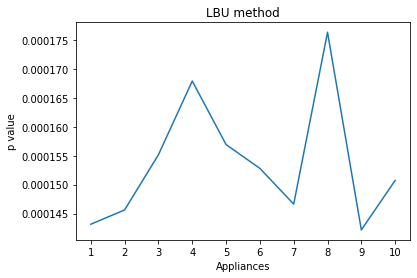

In [7]:
avg_pvalue_lbu = []
for i in range (no_of_appliances):
    sum_val = 0
    for k in range (no_of_days):
        sum_val = sum_val + final_output['D' + str(k + 1)]['A' + str(i+1)]['kw_pval']
    avg = sum_val/no_of_days
    avg_pvalue_lbu.append(avg)

x = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
ax = sns.lineplot(x=x, y=avg_pvalue_lbu)
ax.set(xlabel='Appliances', ylabel='p value', title='LBU method')
plt.savefig('skewLBU.pdf')

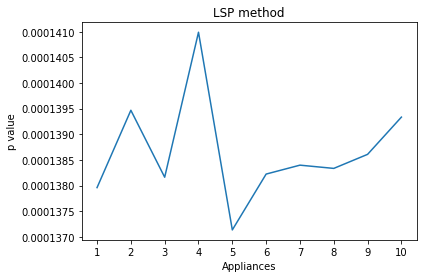

In [10]:
avg_pvalue_lsp = []
for i in range (no_of_appliances):
    sum_val = 0
    for k in range (no_of_days):
        sum_val = sum_val + final_output['D' + str(k + 1)]['A' + str(i+1)]['kw_pval']
    avg = sum_val/no_of_days
    avg_pvalue_lsp.append(avg)

x = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
ax = sns.lineplot(x=x, y=avg_pvalue_lsp)
ax.set(xlabel='Appliances', ylabel='p value', title='LSP method')
plt.savefig('skewLSP.pdf')

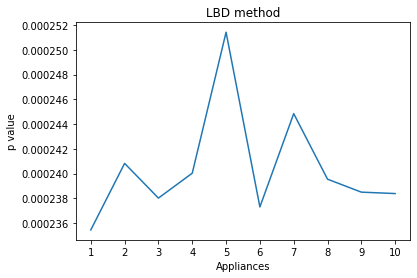

In [13]:
avg_pvalue_lbd = []
for i in range (no_of_appliances):
    sum_val = 0
    for k in range (no_of_days):
        sum_val = sum_val + final_output['D' + str(k + 1)]['A' + str(i+1)]['kw_pval']
    avg = sum_val/no_of_days
    avg_pvalue_lbd.append(avg)

x = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
ax = sns.lineplot(x=x, y=avg_pvalue_lbd)
ax.set(xlabel='Appliances', ylabel='p value', title='LBD method')
plt.savefig('skewLBD.pdf')

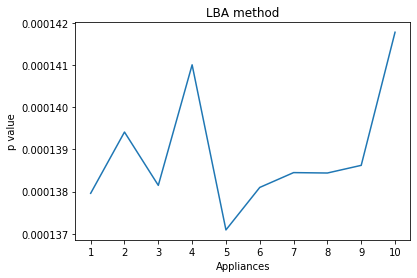

In [16]:
avg_pvalue_lba = []
for i in range (no_of_appliances):
    sum_val = 0
    for k in range (no_of_days):
        sum_val = sum_val + final_output['D' + str(k + 1)]['A' + str(i+1)]['kw_pval']
    avg = sum_val/no_of_days
    avg_pvalue_lba.append(avg)

x = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
ax = sns.lineplot(x=x, y=avg_pvalue_lba)
ax.set(xlabel='Appliances', ylabel='p value', title='LBA method')
plt.savefig('skewLBA.pdf')

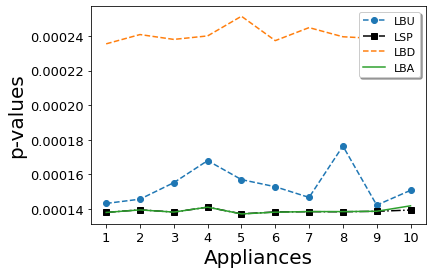

In [19]:
# For method comparion
import matplotlib.pyplot as plt
import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D
import numpy as np
plt.rcParams.update({'font.size': 13})

fig, ax = plt.subplots()

l1, = ax.plot(x, avg_pvalue_lbu, '--o')
l2, = ax.plot(x, avg_pvalue_lsp, 's-.', color= 'black')
l3, = ax.plot(x, avg_pvalue_lbd, '--')
l4, = ax.plot(x, avg_pvalue_lba)

# l2, l3 = ax.plot(t2, np.sin(2 * np.pi * t2), '--o', t1, np.log(1 + t1), '.')
# l4, = ax.plot(t2, np.exp(-t2) * np.sin(2 * np.pi * t2), 's-.')

ax.legend((l1, l2, l3, l4), ('LBU', 'LSP', 'LBD', 'LBA'), loc='upper right', fontsize=11, shadow=True)
ax.set_xlabel('Appliances', fontsize=20)
ax.set_ylabel('p-values', fontsize=20)
# ax.set_title('The Kruskal-Wallis similarty test p values for each appliances', fontsize=14)
# plt.show()
plt.savefig('skew_methods.pdf',dpi=300, bbox_inches = "tight")
# plt.savefig('real_methods.pdf')

In [18]:
lbu_a = np.average(avg_pvalue_lbu)
lsp_a = np.average(avg_pvalue_lsp)
lbd_a = np.average(avg_pvalue_lbd)
lba_a = np.average(avg_pvalue_lba)
print(lbu_a, lsp_a, lbd_a, lba_a)

0.0001537515525247164 0.00013866108786392078 0.00024043552017738277 0.00013890146480901962


Minimum value: 323.6391001379871
Maximum value: 3000.0


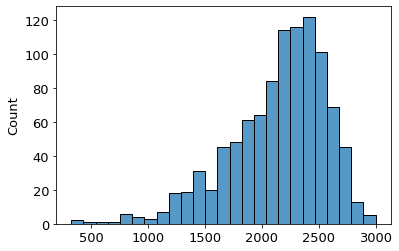

In [24]:
#Testing

from scipy.stats import skewnorm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set skew parameter
skew = -4
a, b = 1, 3000

# Generate random numbers from a skewed normal distribution
x = skewnorm.rvs(skew, loc = 2000, scale = 500, size=1000)

# Scale the numbers to the desired range
x = x / np.max(np.abs(x))
x = x * (b-a) + a

x[x<0] = 1
len(x)

# Check range of generated numbers
print("Minimum value:", np.min(x))
print("Maximum value:", np.max(x))

sns.histplot(data = x)
plt.show()